# Для запуска в colab

In [49]:
# fast версия для pymotphy2 не работает на python3.7!!!
# Использовать только python3.6 либо python3.8
# !pip install --user bigartm10 pymorphy2[fast] pyLDAvis

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# Библиотеки

In [343]:
import itertools

from tqdm.notebook import tqdm
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
# не очень много стоп слов, но для задания хватит
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import pymorphy2
import nltk
import gc

import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [ ]:
nltk.download('stopwords')

# Работа с данными

## Загрузка датасета

In [5]:
data = pd.read_csv('drive/MyDrive/DATASETS/MachineLearning/topicmodeling/lenta-ru-filtered.csv')

## Анализ

In [6]:
data

,text,tags,len,date
0,С 1 сентября на всей территории России вводитс...,Все,1654,31-08-1999
1,"По сведениям миссии ООН, передаваемым РИА ""Нов...",Все,1086,31-08-1999
2,15 представителей национал-большевистской парт...,Все,1219,31-08-1999
3,Намеченная на сегодняшний день церемония вступ...,Все,3094,31-08-1999
4,"На юге Киргизии, а именно в Баткенском и Чон-А...",Все,1354,31-08-1999
...,...,...,...,...
863280,Популярное место среди туристов в Мурманской о...,Россия,1231,11-09-2020
863281,Рейтинги от международного рейтингового агентс...,NaN,1425,11-09-2020
863282,Российские ученые нашли в Якутии новый подвид ...,События,1299,11-09-2020
863283,Для указания коронавируса как причины смерти ч...,Общество,2061,11-09-2020


In [7]:
data.describe()

,len
count,863285.000000
mean,1341.245505
std,572.066583
min,3.000000
25%,980.000000
50%,1253.000000
75%,1596.000000
max,55387.000000


Видно, что новостные заметки занимают порядка 1.2 кб текста, что является порядка 3/4 страницы А4 печатного текста. Данная длина текста приемлема для анализа, так как не является слишком короткими (как например твиты, порядка 0.2 кб).

Заметим, что в данных присутсвует поле tags (посути это можно рассматривать как топик). Данное поле будет интерестно в последующем анализе.

In [8]:
topics = [x.lower() for x in np.unique(np.array(data['tags'].values, dtype=str)).tolist() if x != 'nan']

In [9]:
len(topics), topics[:10]

(94,
 ['69-я параллель',
  'coцсети',
  'авто',
  'автобизнес',
  'аналитика рынка',
  'английский футбол',
  'белоруссия',
  'бизнес',
  'бокс и мма',
  'вещи'])

## Предобработка

Выполним простую предобработку текстов:
- lowercase;
- лемматизация при помощи pymorphy2;
- удаление стоп слов из словаря nltk.

In [10]:
# Честно взято с реализации ru_sentencetokenizer от iPavlov.
# Переписано в класс (к сожалению очень давно переписал и быстро сами пакет от 
#          iPavlov найти не смог,мне быстрее было взять свой пофикшеный код...)
import re
import logging
from typing import Set, Tuple, List
class RuSentenceTokenizer(object):
    def __init__(self):
        self.SENT_RE = re.compile(r'[^\.?!…]+[\.?!…]*["»“]*')

        self._LAST_WORD = re.compile(r'(?:\b|\d)([a-zа-я]+)\.$', re.IGNORECASE)
        self._FIRST_WORD = re.compile(r'^\W*(\w+)')
        self._ENDS_WITH_ONE_LETTER_LAT_AND_DOT = re.compile(r'(\d|\W|\b)([a-zA-Z])\.$')
        self._HAS_DOT_INSIDE = re.compile(r'[\w]+\.[\w]+\.$', re.IGNORECASE)
        self._INITIALS = re.compile(r'(\W|\b)([A-ZА-Я]{1})\.$')
        self._ONLY_RUS_CONSONANTS = re.compile(r'^[бвгджзйклмнпрстфхцчшщ]{1,4}$', re.IGNORECASE)
        self._STARTS_WITH_EMPTYNESS = re.compile(r'^\s+')
        self._ENDS_WITH_EMOTION = re.compile(r'[!?…]|\.{2,}\s?[)"«»,“]?$')
        self._STARTS_WITH_LOWER = re.compile(r'^\s*[–-—-("«]?\s*[a-zа-я]')
        self._STARTS_WITH_DIGIT = re.compile(r'^\s*\d')
        self._NUMERATION = re.compile(r'^\W*[IVXMCL\d]+\.$')
        self._PAIRED_SHORTENING_IN_THE_END = re.compile(r'\b(\w+)\. (\w+)\.\W*$')

        self._JOIN = 0
        self._MAYBE = 1
        self._SPLIT = 2

        self.JOINING_SHORTENINGS = {'mr', 'mrs', 'ms', 'dr', 'vs', 'англ', 'итал', 'греч', 'евр', 'араб', 'яп', 'слав', 'кит',
                               'тел', 'св', 'ул', 'устар', 'им', 'г', 'см', 'д', 'стр', 'корп', 'пл', 'пер', 'сокр', 'рис'}
        self.SHORTENINGS = {'co', 'corp', 'inc', 'авт', 'адм', 'барр', 'внутр', 'га', 'дифф', 'дол', 'долл', 'зав', 'зам', 'искл',
                       'коп', 'корп', 'куб', 'лат', 'мин', 'о', 'обл', 'обр', 'прим', 'проц', 'р', 'ред', 'руб', 'рус', 'русск',
                       'сан', 'сек', 'тыс', 'эт', 'яз', 'гос', 'мн', 'жен', 'муж', 'накл', 'повел', 'букв', 'шутл', 'ед'}

        self.PAIRED_SHORTENINGS = {('и', 'о'), ('т', 'е'), ('т', 'п'), ('у', 'е'), ('н', 'э')}
        
        # whitespaces
        self.start_whitespace = re.compile('^\s+')
        self.end_whitespace = re.compile('\s+$')
    
    
    def _regex_split_separators(self, text: str) -> [str]:
        return [x.strip() for x in self.SENT_RE.findall(text)]
    
    def _is_sentence_end(self, left: str, 
                               right: str,
                               shortenings: Set[str],
                               joining_shortenings: Set[str],
                               paired_shortenings: Set[Tuple[str, str]]) -> int:
        if not self._STARTS_WITH_EMPTYNESS.match(right):
            return self._JOIN

        if self._HAS_DOT_INSIDE.search(left):
            return self._JOIN

        left_last_word = self._LAST_WORD.search(left)
        lw = ' '
        if left_last_word:
            lw = left_last_word.group(1)

            if lw.lower() in joining_shortenings:
                return self._JOIN

            if self._ONLY_RUS_CONSONANTS.search(lw) and lw[-1].islower():
                return self._MAYBE

        pse = self._PAIRED_SHORTENING_IN_THE_END.search(left)
        if pse:
            s1, s2 = pse.groups()
            if (s1, s2) in paired_shortenings:
                return self._MAYBE

        right_first_word = self._FIRST_WORD.match(right)
        if right_first_word:
            rw = right_first_word.group(1)
            if (lw, rw) in paired_shortenings:
                return self._MAYBE

        if self._ENDS_WITH_EMOTION.search(left) and self._STARTS_WITH_LOWER.match(right):
            return self._JOIN

        initials = self._INITIALS.search(left)
        if initials:
            border, _ = initials.groups()
            if (border or ' ') not in "°'":
                return self._JOIN

        if lw.lower() in shortenings:
            return self._MAYBE

        last_letter = self._ENDS_WITH_ONE_LETTER_LAT_AND_DOT.search(left)
        if last_letter:
            border, _ = last_letter.groups()
            if (border or ' ') not in "°'":
                return self._MAYBE
        if self._NUMERATION.match(left):
            return self._JOIN
        return self._SPLIT
    
    def tokenize(self, text: str,
                       shortenings: Set[str] = None,
                       joining_shortenings: Set[str] = None,
                       paired_shortenings: Set[Tuple[str, str]] = None) -> List[str]:
        
        spans = self.span_tokenize(text, shortenings, joining_shortenings, paired_shortenings)
        
        sentences = []
        for span in spans:
            sentences.append(text[span[0]:span[1]])
        
        return sentences
    
    def _span_strip(self, text, sent_start, span_end):
        # delete whitespace start spans
        start_whitespace = self.start_whitespace.search(text[sent_start: span_end])
        if start_whitespace:
            sent_start += (start_whitespace.span(0)[1] - start_whitespace.span(0)[0])
        # delete whitespace end spans
        end_whitespace = self.end_whitespace.search(text[sent_start: span_end])
        if end_whitespace:
            span_end -= (end_whitespace.span(0)[1] - end_whitespace.span(0)[0])
            
        return sent_start, span_end
    
    def span_tokenize(self, text,
                            shortenings: Set[str] = None,
                            joining_shortenings: Set[str] = None,
                            paired_shortenings: Set[Tuple[str, str]] = None) -> List[Tuple]:
        
        if shortenings is None:
            shortenings = self.SHORTENINGS
        if joining_shortenings is None:
            joining_shortenings = self.JOINING_SHORTENINGS
        if paired_shortenings is None:
            paired_shortenings = self.PAIRED_SHORTENINGS
    
        spans = []
        sents = self._regex_split_separators(text)
        si = 0
        processed_index = 0
        sent_start = 0
        while si < len(sents):
            s = sents[si]
            span_start = text[processed_index:].index(s) + processed_index
            span_end = span_start + len(s)
            processed_index += len(s)

            si += 1

            send = self._is_sentence_end(text[sent_start: span_end], 
                                         text[span_end:],
                                         shortenings, 
                                         joining_shortenings, 
                                         paired_shortenings)
            if send == self._JOIN:
                continue

            if send == self._MAYBE:
                if self._STARTS_WITH_LOWER.match(text[span_end:]):
                    continue
                if self._STARTS_WITH_DIGIT.match(text[span_end:]):
                    continue
                    
            sent_start, span_end = self._span_strip(text, sent_start, span_end)

            if not text[sent_start: span_end].strip():
                logging.debug("Something went wrong while tokenizing")
            else:
                spans.append((sent_start, span_end))
            
            sent_start = span_end
            processed_index = span_end

        if sent_start != len(text):
            if text[sent_start:].strip():
                sent_start, span_end = self._span_strip(text, sent_start, len(text))
                spans.append((sent_start, span_end))
        return spans

In [11]:
# уже давно пользуюсь для себя унифицированными токенизаторами
word_tokenizer = RegexpTokenizer('[a-zа-яёЁА-ЯA-Z]+|[^\w\s]|\d+')
sent_tokenizer = RuSentenceTokenizer()
# pymorphy2 анализатор
morph = pymorphy2.MorphAnalyzer()
# стоп слова из nltk
stops = stopwords.words('russian')

In [12]:
def proccess_text(text):
    text= text.lower()
    sents = sent_tokenizer.tokenize(text)
    words = list(
        itertools.chain.from_iterable(
            word_tokenizer.tokenize_sents(sents)))
    return [x for x in [morph.normal_forms(word)[0] for word in words ]\
            if x not in stops]

In [319]:
# data_text = data['text']
# for i in tqdm(range(len(data))):
#     data_text.loc[i] = ' '.join(proccess_text(data_text.loc[i]))
# data.to_csv('drive/MyDrive/DATASETS/MachineLearning/topicmodeling/lenta-ru-proccess.csv', index=False)

# препроцесинг занимает порядка двух часов, поэтому рекомендуется загрузисть
# сразу обработанную версию
data = pd.read_csv('drive/MyDrive/DATASETS/MachineLearning/topicmodeling/lenta-ru-proccess.csv')

In [320]:
data

,text,tags,len,date
0,1 сентябрь весь территория россия вводиться но...,Все,1654,31-08-1999
1,"сведение миссия оон , передаваемый риа "" новос...",Все,1086,31-08-1999
2,15 представитель национал - большевистский пар...,Все,1219,31-08-1999
3,наметить сегодняшний день церемония вступление...,Все,3094,31-08-1999
4,"юг киргизия , именно баткенский чон - алайском...",Все,1354,31-08-1999
...,...,...,...,...
863280,популярный место среди турист мурманский облас...,Россия,1231,11-09-2020
863281,рейтинг международный рейтинговый агентство s ...,NaN,1425,11-09-2020
863282,российский учёный найти якутия новый подвид ар...,События,1299,11-09-2020
863283,указание коронавирус причина смерть человек не...,Общество,2061,11-09-2020


## Перевод данных в формат данных для bigartm (+ деление на train/valid)

In [ ]:
filename_valid = 'drive/MyDrive/DATASETS/MachineLearning/topicmodeling/texts_valid.vw.txt'
filename_train = 'drive/MyDrive/DATASETS/MachineLearning/topicmodeling/texts_train.vw.txt'

y_train = []
y_valid = []

counter_train = 0
counter_valid = 0

reg = re.compile(r'\W+')
with open(filename_valid, 'w') as fout_valid:
    with open(filename_train, 'w') as fout_train:
        for i in tqdm(range(len(data))):
            text = (reg.sub(' ', data.loc[i]['text']).strip()).split()
            label = '_'.join(data.loc[i]['date'].split('-')[1:])


            if len(text) > 100:
                if (i + 1) % 100 == 0:
                    fout_valid.write('doc_{} {} |@month class_{}\n'.format(counter_train, ' '.join(text), label))
                    counter_train += 1
                    y_valid.append(str(data.loc[i]['tags']).lower().strip())
                else:
                    fout_train.write('doc_{} {} |@month class_{}\n'.format(counter_valid, ' '.join(text), label))
                    counter_valid += 1
                    y_train.append(str(data.loc[i]['tags']).lower().strip())
                    

In [ ]:
# освободим немного память
del data

gc.collect()

In [177]:
!head -2 drive/MyDrive/DATASETS/MachineLearning/topicmodeling/texts_valid.vw.txt

doc_0 причина смерть меньший мера 34 малазийский ребёнок возраст 5 месяц 7 год стать неизвестный вирус вызывающий прекращение деятельность сердце мозг утверждать учёный проводить свой исследование страна это сегодня утром сообщить радиостанция ввс первоначально предполагаться причина смерть стать давно известный врач сезонный лихорадка однако поздний выясниться сердце мозг ребёнок поразить неизвестный вирус наблюдение пациент госпиталь субить опубликовать исследователь журнал the lancet доказать большинство умерший ребёнок развиться миокардит воспаление мозг вызвать сезонный лихорадка возбудитель болезнь признанный аденовирус назвать учёный agent y правило аденовирус опасный жизнь вызывать нетяжелый заболевание тип известный простуда однако именно agent y обнаружить исследование ткань сердце мозг погибший ребёнок учёный вынудить признать видимо речь идти новый разновидность вирус возникнуть южный азия утверждение bbc вспышка похожий заболевание произойти 1998 год тайвань |@month class_

In [178]:
!wc -l drive/MyDrive/DATASETS/MachineLearning/topicmodeling/texts_valid.vw.txt

6604 drive/MyDrive/DATASETS/MachineLearning/topicmodeling/texts_valid.vw.txt


In [179]:
!head -2 drive/MyDrive/DATASETS/MachineLearning/topicmodeling/texts_train.vw.txt

doc_0 1 сентябрь весь территория россия вводиться новый форма таможенный декларация физический лицо пояснить государственный таможенный комитет гтк форма декларация который одобрить совет руководитель таможенный служба государство участник содружество являться единый территория весь страна снг исключение армения данные итар тасс новый декларация содержаться подробный перечень товар подлежащее обязательный декларирование впервые число включить ядовитый сильно действующий вещество лекарство радиоактивный материал объект флор фауна также высокочастотный радио электронный устройство средство связь частность система радиолокация кабельный телевидение средство мобильный связь частота выше 9 килогерц кроме декларация необходимый приводить подробный сведение ввозить вывозить транспортный средство вид машинs год выпуск объесть двигатель номер двигатель кузов шасси россия новый форма декларация наряду прежний применяться 1 август лишь московский таможенный пункт шереметьево внуково домодедово чк

In [180]:
!wc -l drive/MyDrive/DATASETS/MachineLearning/topicmodeling/texts_train.vw.txt

653795 drive/MyDrive/DATASETS/MachineLearning/topicmodeling/texts_train.vw.txt


# BigARTM модель

In [181]:
import artm
import pyLDAvis

In [182]:
artm.ARTM(num_topics=1)
print(artm.version())

0.9.2


## Создаем батчи

In [185]:
bv_train = artm.BatchVectorizer(data_path=filename_train, 
                                data_format='vowpal_wabbit', 
                                batch_size=10000, 
                                target_folder='drive/MyDrive/DATASETS/MachineLearning/topicmodeling/batches_train')


In [187]:
# Важно, пути target_folder должны быть отличны от предыдущей
bv_test = artm.BatchVectorizer(data_path=filename_valid, 
                               data_format='vowpal_wabbit', 
                               batch_size=10000, 
                               target_folder='drive/MyDrive/DATASETS/MachineLearning/topicmodeling/batches_valid')



## Создаем словарь слов по заданым батчам

In [188]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='drive/MyDrive/DATASETS/MachineLearning/topicmodeling/batches_train')

## Инициализируем модель

In [189]:
model = artm.ARTM(num_topics=200,
                  dictionary=dictionary, 
                  class_ids={'@default_class': 1.0, 
                             '@month': 10.0})

model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=bv.dictionary))
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
model.scores.add(artm.SparsityPhiScore(name='sparsity', class_id='@month'))

## Обучаем модель с самого начала, без регуляризаторов

In [272]:
iterator = tqdm(range(1))
for i in iterator:
    model.fit_offline(bv_train, num_collection_passes=1)
    iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],  
                          'sparsity': model.score_tracker['sparsity'].value[-1],})

In [193]:
# model.dump_artm_model('drive/MyDrive/DATASETS/MachineLearning/topicmodeling/model/without_regular')

## Анализ скоров моделей

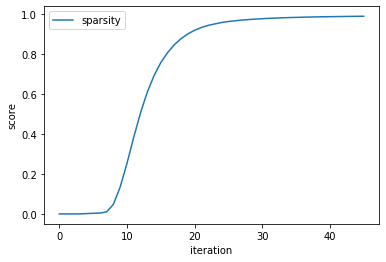

In [198]:
plt.plot(model.score_tracker['sparsity'].value, label = 'sparsity')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

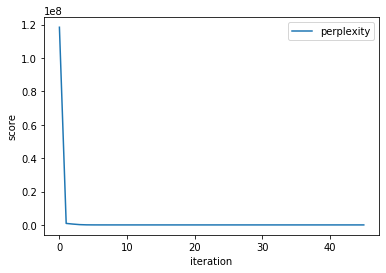

In [199]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

## Посмотрим на полученые топики

In [192]:
top_tokens = model.score_tracker['top-tokens'].last_tokens

for topic_name in model.topic_names:
    print(top_tokens[topic_name])

['учёный', 'исследование', 'который', 'исследователь', 'человек', 'анализ', 'вывод', 'клетка', 'журнал', 'это']
['английский', 'перейти', 'переход', 'лондонский', 'англия', 'который', 'челси', 'манчестер', 'арсенал', 'это']
['германия', 'немецкий', 'который', 'берлин', 'фрг', 'меркель', 'канцлер', 'свой', 'ангел', 'австрия']
['создать', 'создание', 'зона', 'который', 'конференция', 'структура', 'объединить', 'новый', 'объединение', 'весь']
['решение', 'принять', 'должный', 'срок', 'договор', 'условие', 'документ', 'отказ', 'подписать', 'отказаться']
['заявление', 'отношение', 'ситуация', 'выразить', 'мид', 'заявить', 'позиция', 'свой', 'подчеркнуть', 'интерес']
['министерство', 'ведомство', 'чиновник', 'внутренний', 'департамент', 'государственный', 'анатолий', 'глава', 'оборона', 'юстиция']
['октябрь', '17', '23', '26', '18', '13', '21', '27', '14', 'это']
['июль', 'культура', 'это', 'который', 'деятель', 'вино', 'сообщать', 'никита', 'также', 'соколов']
['индия', 'индийский', 'пакист

In [ ]:
month_modal = []
with open('drive/MyDrive/DATASETS/MachineLearning/topicmodeling/texts_train.vw.txt') as f:
    for line in tqdm(f):
        string = re.search(r'@month class_(\d\d_\d\d\d\d)\n', line).group(1)
        month_modal.append(datetime.datetime.strptime(string, '%m_%Y'))

month_modal = np.array(month_modal)

In [201]:
predict = model.transform(bv_train)

In [202]:
unique_modal = np.unique(month_modal)

In [ ]:
mean_vectors = []
for modal in tqdm(unique_modal):
    mean_vectors.append(predict[np.where(month_modal == modal)[0]].values.mean(axis=-1))
    
mean_vectors = np.array(mean_vectors)

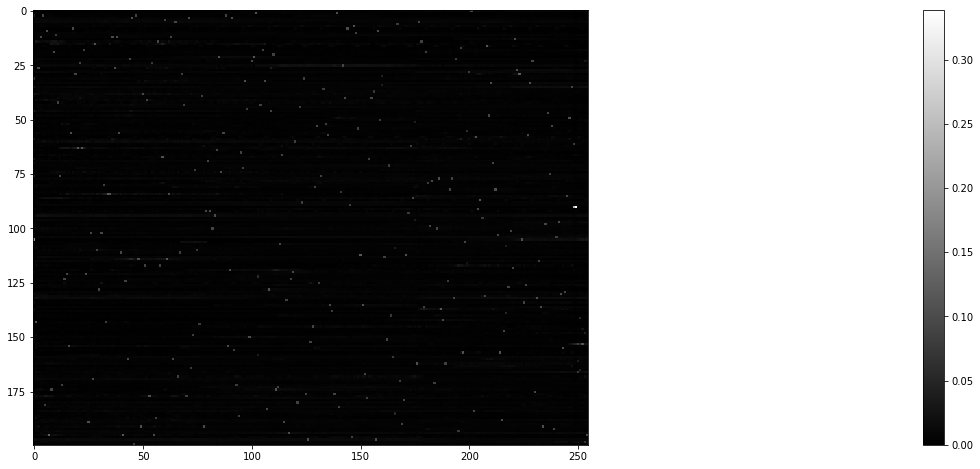

In [234]:
fig = plt.figure(figsize=(120, 8))

im = plt.imshow(mean_vectors.T, cmap='gray')
_ = fig.colorbar(im)

plt.show()

### Очень много явных топиков (большой шум на изображении)
Посмотрим на эти пики

In [242]:
for modal_id, topic_id in zip(*np.where(mean_vectors > 0.10)):
    print(unique_modal[modal_id].strftime('%Y-%m'), 
          ','.join(top_tokens[model.topic_names[topic_id]]))

1914-09 фотография,twitter,пользователь,опубликовать,снимка,фото,instagram,девушка,аккаунт,который
1999-08 северный,южный,остров,япония,корея,визит,японский,кндр,пхеньян,южнокорейский
2000-01 индия,индийский,пакистан,послание,который,пакистанский,сообщать,это,сентябрь,дубай
2000-02 республика,чечня,чеченский,кадыров,глава,это,грозный,руслан,который,татарстан
2000-12 пожар,мчс,авария,пожарный,ликвидация,последствие,чрезвычайный,экологический,склад,возгорание
2001-03 фильм,роль,картина,режиссёр,актёр,сыграть,прокат,главный,съёмка,который
2001-05 фильм,роль,картина,режиссёр,актёр,сыграть,прокат,главный,съёмка,который
2001-08 часы,00,час,путь,поезд,около,приостановить,суббота,утром,утро
2001-11 минута,счёт,й,матч,0,очки,1,победа,встреча,ворот
2002-05 израиль,израильский,палестинский,сектор,газа,хамас,автономия,палестинец,еврейский,который
2002-06 израиль,израильский,палестинский,сектор,газа,хамас,автономия,палестинец,еврейский,который
2002-08 грузия,грузинский,осетия,саакашвили,абхазия,южн

### Удалим слишком большие засветы тем

In [224]:
damage_mean_vectors = mean_vectors.copy()
damage_mean_vectors[np.where(mean_vectors > 0.1)] = 0

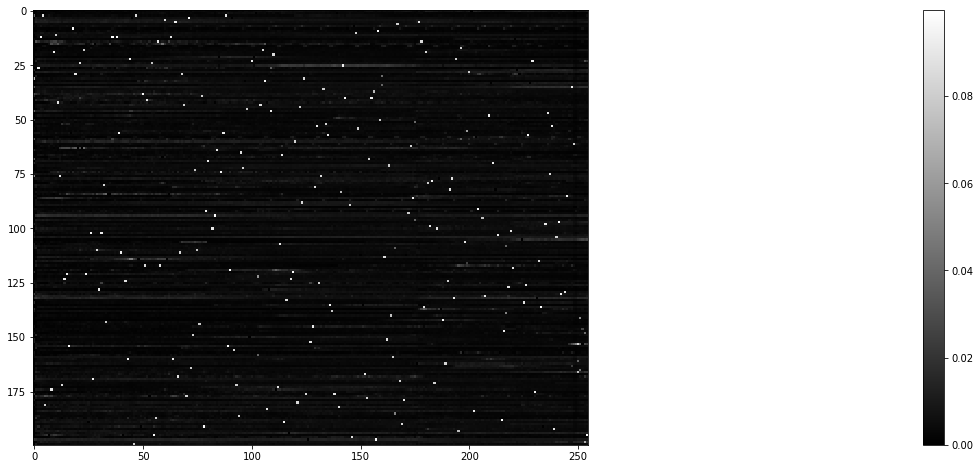

In [261]:
fig = plt.figure(figsize=(120, 8))

im = plt.imshow(damage_mean_vectors.T, cmap='gray')
_ = fig.colorbar(im)

plt.show()

### Появились интересные топики сквозь года - посмотрим на них

In [268]:
','.join(top_tokens[model.topic_names[60]])

'суд,признать,иск,подать,судебный,адвокат,приговор,судья,решение,жалоба'

In [270]:
','.join(top_tokens[model.topic_names[95]])

'группа,the,a,and,i,of,коллектив,in,to,for'

In [255]:
','.join(top_tokens[model.topic_names[129]])

'участие,пройти,участник,принимать,мероприятие,принять,конкурс,участвовать,проходить,организатор'

In [256]:
','.join(top_tokens[model.topic_names[198]])

'проект,программа,развитие,план,рамка,планироваться,сфера,новый,реализация,поддержка'

### Анализ матрицы $\Phi$

In [296]:
vector_pd = model.get_phi(class_ids=['@month']).T

In [ ]:
vectors = []
for modal in tqdm(unique_modal):
    vectors.append(vector_pd['class_' + modal.strftime('%m_%Y')].values)
    
vectors = np.array(vectors).T

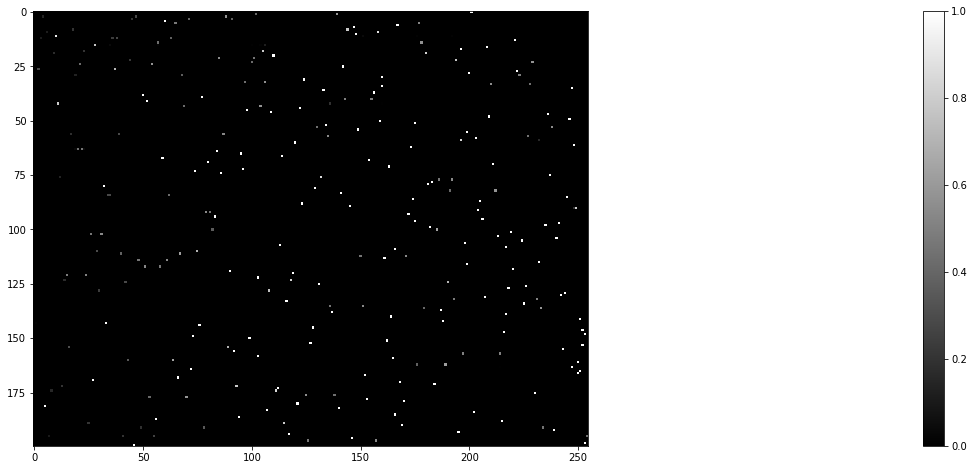

In [311]:
fig = plt.figure(figsize=(120, 8))

im = plt.imshow(vectors, cmap='gray')
_ = fig.colorbar(im)

plt.show()

In [318]:
for modal_id, topic_id in zip(*np.where(vectors.T > 0.999)):
    print(unique_modal[modal_id].strftime('%Y-%m'), 
          ','.join(top_tokens[model.topic_names[topic_id]][:7]))

1999-12 граница,судно,порт,судный,груз,берег,пограничный
2001-10 информация,сведение,дать,times,спецслужба,документ,опровергнуть
2002-03 власть,иностранный,политический,обратиться,предоставить,просьба,статус
2003-05 свобода,заключение,приговорить,тюрьма,наказание,осудить,лишение
2003-09 человек,погибнуть,взрыв,погибший,теракт,жертва,результат
2003-11 партия,единый,лидер,депутат,политический,госдума,демократический
2004-03 станция,космический,корабль,полёт,мкс,космос,рогозин
2004-06 команда,сборный,тренер,чемпионат,италия,сборная,итальянский
2004-07 решение,принять,должный,срок,договор,условие,документ
2005-01 акция,массовый,протест,человек,митинг,против,беспорядок
2005-07 статья,рф,уголовный,факт,следственный,возбудить,дело
2005-08 активист,административный,ответственность,устроить,привлечь,сутки,протокол
2005-09 школа,язык,образование,институт,университет,студент,наука
2005-11 франция,французский,париж,блэр,de,француз,жан
2005-12 хороший,премия,книга,церемония,роман,награда,получить
2

### Вспомним, что в выборке есть тэги классов. Попробуем решить задачу классификации

In [326]:
X_train_pd = model.transform(bv_train)

In [ ]:
X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)

In [335]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [325]:
classifier = RandomForestClassifier(n_estimators=10)

In [336]:
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [337]:
X_valid_pd = model.transform(bv_test)

In [ ]:
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

In [342]:
pred = classifier.predict(X_valid)

In [346]:
print(classification_report(y_valid, pred, zero_division=1))

                      precision    recall  f1-score   support

             coцсети       0.21      0.21      0.21        39
                 nan       0.37      0.34      0.35       208
          автобизнес       1.00      0.50      0.67         2
   английский футбол       1.00      1.00      1.00         1
          белоруссия       0.80      0.33      0.47        24
              бизнес       0.24      0.20      0.22        70
          бокс и мма       0.90      0.56      0.69        32
                вещи       1.00      0.00      0.00         5
     вирусные ролики       1.00      0.00      0.00         2
         внешний вид       0.53      0.50      0.52        16
                 все       0.68      0.96      0.80      3356
             гаджеты       0.53      0.33      0.41        24
               город       0.20      0.06      0.09        18
        госэкономика       0.53      0.36      0.43       162
                дача       1.00      0.00      0.00        13
       

## Продолжаем обучать модель, добавив регуляризаторы
- Добавим декорелирующий регуляризатор на токены
- Добавим сглаживающий регуляризатор на время

In [347]:
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator', 
                                                       tau=1e+4, 
                                                       class_ids=['@default_class']))

model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='smoothing', 
                                                       tau=10,
                                                       class_ids=['@month']))


In [ ]:
iterator = tqdm(range(20))
for i in iterator:
    model.fit_offline(bv_train, num_collection_passes=1)
    iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],  
                          'sparsity': model.score_tracker['sparsity'].value[-1],})

In [ ]:
model.dump_artm_model('drive/MyDrive/DATASETS/MachineLearning/topicmodeling/model/model_regular')

## Анализ скоров моделей

In [ ]:
plt.plot(model.score_tracker['sparsity'].value, label = 'sparsity')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

## Анализ скоров моделей

In [ ]:
plt.plot(model.score_tracker['sparsity'].value, label = 'sparsity')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

In [ ]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

## Посмотрим на полученые топики

In [ ]:
top_tokens = model.score_tracker['top-tokens'].last_tokens

for topic_name in model.topic_names:
    print(top_tokens[topic_name])

In [ ]:
month_modal = []
with open('drive/MyDrive/DATASETS/MachineLearning/topicmodeling/texts_train.vw.txt') as f:
    for line in tqdm(f):
        string = re.search(r'@month class_(\d\d_\d\d\d\d)\n', line).group(1)
        month_modal.append(datetime.datetime.strptime(string, '%m_%Y'))

month_modal = np.array(month_modal)

In [ ]:
predict = model.transform(bv_train)

In [ ]:
unique_modal = np.unique(month_modal)

In [ ]:
mean_vectors = []
for modal in tqdm(unique_modal):
    mean_vectors.append(predict[np.where(month_modal == modal)[0]].values.mean(axis=-1))
    
mean_vectors = np.array(mean_vectors)

In [ ]:
fig = plt.figure(figsize=(120, 8))

im = plt.imshow(mean_vectors.T, cmap='gray')
_ = fig.colorbar(im)

plt.show()

### Анализ матрицы $\Phi$

In [ ]:
vector_pd = model.get_phi(class_ids=['@month']).T

In [ ]:
vectors = []
for modal in tqdm(unique_modal):
    vectors.append(vector_pd['class_' + modal.strftime('%m_%Y')].values)
    
vectors = np.array(vectors).T

In [ ]:
fig = plt.figure(figsize=(120, 8))

im = plt.imshow(vectors, cmap='gray')
_ = fig.colorbar(im)

plt.show()

In [ ]:
for modal_id, topic_id in zip(*np.where(vectors.T > 0.999)):
    print(unique_modal[modal_id].strftime('%Y-%m'), 
          ','.join(top_tokens[model.topic_names[topic_id]][:7]))

### Вспомним, что в выборке есть тэги классов. Попробуем решить задачу классификации

In [ ]:
X_train_pd = model.transform(bv_train)

In [ ]:
X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
classifier = RandomForestClassifier(n_estimators=10)

In [ ]:
classifier.fit(X_train, y_train)

In [ ]:
X_valid_pd = model.transform(bv_test)

In [ ]:
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

In [ ]:
pred = classifier.predict(X_valid)

In [ ]:
print(classification_report(y_valid, pred, zero_division=1))